In [1]:
import numpy as np

import xarray as xr
from matplotlib import pyplot as plt
%matplotlib inline

from xhistogram.xarray import histogram
import dask.dataframe as dd
import cartopy.crs as ccrs
import cartopy.feature as cfeature

import mitequinox.utils as ut
from mitequinox.plot import *
import mitequinox.parcels as pa
from xmitgcm import llcreader

from fsspec.implementations.local import LocalFileSystem

INFO: Compiled ParcelsRandom ==> /dev/shm/pbs.5116549.datarmor0/parcels-502090/libparcels_random_0ca666c6-1f89-4f91-ab56-fa24d1062c59.so


In [2]:
from dask.distributed import Client, LocalCluster
#
#cluster = LocalCluster()
#
from dask_jobqueue import PBSCluster
cluster = PBSCluster() #processes=7, cores=7
w = cluster.scale(jobs=7)
#
client = Client(cluster)

In [4]:
client

Client Scheduler: tcp://10.148.0.226:56398 Dashboard: http://10.148.0.226:8787/status,Cluster Workers: 14 Cores: 14 Memory: 223.58 GiB


In [5]:
# Lagrangian data
root_dir = '/home1/datawork/aponte/parcels/'
run_name = 'global_extra_T365j_dt1j_dij50'

p = pa.parcels_output(root_dir+run_name, parquets=['time_mean'])
df = p.df['time_mean']
df = pa.degs2ms(df) #Convert in m/s 


In [6]:
df_sub = df.drop(columns=['sea_level','temperature','salinity','Eta_interp','SSS_interp','SST_interp'])
df_sub = df_sub.rename(columns={'SSU_interp':'mean_zonal_velocity','SSV_interp':'mean_meridional_velocity'})
df_sub = df_sub.persist()
#df_sub = df_sub.get_partition(0).persist()
df_sub

,trajectory,lat,lon,z,zonal_velocity,meridional_velocity,mean_zonal_velocity,mean_meridional_velocity
npartitions=749,,,,,,,,
,int32,float64,float64,float64,float64,float32,float64,float64
,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...


In [45]:
lonmin,latmin,lonmax,latmax = [16,-42,25,-35]

In [46]:
df_bis = df_sub[df_sub.lon<lonmax].persist()
df_bis = df_bis[df_bis.lon>lonmin].persist()
df_bis = df_bis[df_bis.lat<latmax].persist()
df_bis = df_bis[df_bis.lat>latmin].persist()

In [47]:
# Binning the Eulerian mean field (to compare with Lagrangian binned statisitcs)

dl = 1.
lon = np.arange(lonmin,lonmax, dl)
lat = np.arange(latmin, latmax, dl)

df_bis['lon'] = (df_bis['lon']+180)%360 - 180
df_bis['lon_cut'] = df_bis['lon'].map_partitions(pd.cut, lon)
df_bis['lat_cut'] = df_bis['lat'].map_partitions(pd.cut, lat)

In [9]:
# Dates of start and end of simulation
t_start = df_bis.index.min().compute()
t_end = df_bis.index.max().compute()
delta_t = (t_end - t_start)/pd.Timedelta('1D') # in days

print(t_start, t_end, delta_t)

2011-11-15 00:00:00 2012-11-09 01:00:00 360.0416666666667


In [10]:
# temporal bins
#t_bins = pd.date_range(t_start, t_end, freq='1M')
t_bins = pd.date_range(t_start, t_end, freq='1MS') # starts at the beginning of each month
cut = lambda df, bins: pd.cut(df.index.to_series(), bins=bins)

In [11]:
df_bis['time_cut'] = df_bis.map_partitions(cut, t_bins)

In [48]:
df_1dl = df_bis.compute()
#df_01dl = df_bis.compute()

In [49]:

#df_bmean_01 = df_01dl.groupby(group).mean()
for V in ['zonal_velocity','meridional_velocity','mean_zonal_velocity','mean_meridional_velocity']:
    #df_01dl[V+'_transform'] = df_01dl.groupby(group)[V].transform('mean')
    df_1dl[V+'_transform'] = df_1dl.groupby(group)[V].transform('mean')
    df_1dl[V+'_transform_sq'] = df_1dl[V+'_transform']**2
df_1dl['ke_bin'] = df_1dl['zonal_velocity_transform']**2+df_1dl['meridional_velocity_transform']**2
df_1dl['ke_bin_bis'] = df_1dl['zonal_velocity_transform_sq']+df_1dl['meridional_velocity_transform_sq']
df_1dl['ke_inter'] = df_1dl['mean_zonal_velocity_transform']**2+df_1dl['mean_meridional_velocity_transform']**2

In [50]:
group=['lon_cut','lat_cut']
df_bmean = df_1dl.groupby(group).mean()

In [51]:
df_bmean = pa.add_geodata(df_bmean)
ds_bmean = (df_bmean
           .drop(columns=['Coordinates'])
           .set_index(['lon', 'lat'])
           .to_xarray()
           )

In [52]:
df_count = df_1dl.groupby(group).count()
df_count = pa.add_geodata(df_count)



df_count = df_count.drop(columns=['Coordinates']).set_index(['lon', 'lat']).to_xarray()

In [53]:
ds_bmean['count_flts'] = df_count.trajectory

# Eulerian data

In [25]:
def read_Ediag(V,diags):
    ds = xr.merge([ut.load_diagnostic(d+"_"+v).rename({v:d+"_"+v}) 
               for v in V for d in diags])

    grid = xr.open_zarr('/home1/datawork/xyu/grid/mit_grid.zarr')
    ds = xr.merge([ds,grid])
    #ds = ds#.isel(i = slice(0,None,4), j = slice(0,None,4), i_g = slice(0,None,4), j_g = slice(0,None,4))
    ds['lon'] = 0*ds.face+ds.XC
    ds['lat'] = 0*ds.face+ds.YC
    ds = ds.compute()
    # Rotation velocity field
    for diag in diags:
        ds['zonal_velocity_'+diag] =  ds[diag+'_SSU'].rename({'i_g': 'i'})*ds.CS - ds[diag+'_SSV'].rename({'j_g': 'j'})*ds.SN
        ds['meridional_velocity_'+diag] =  ds[diag+'_SSU'].rename({'i_g': 'i'})*ds.SN + ds[diag+'_SSV'].rename({'j_g': 'j'})*ds.CS

        ds['lon'] = 0*ds.face+ds.XC
        ds['lat'] = 0*ds.face+ds.YC
 #   ds = llcreader.faces_dataset_to_latlon(ds)
    return ds

In [26]:
# Eulerian data
V = ["SSU","SSV"]#["SSU", "SSV"]
D = ["mean"]#, "prime_mean","prime_mean_sq"]
ds = read_Ediag(V,D)

In [27]:
ds = ds.isel(face=1)


In [28]:
ds = ds.drop(['i_g','j_g'])

In [57]:
ds_Emean = xr.Dataset({'zonal_velocity_mean':(['lat','lon'],ds.zonal_velocity_mean.values),
                       'meridional_velocity_mean':(['lat','lon'],ds.meridional_velocity_mean.values)},
                      coords={'lon':ds.lon.values[0,:],'lat':ds.lat.values[:,0]})

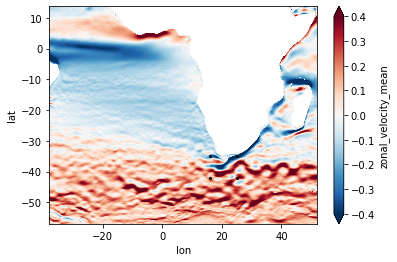

In [58]:
vmax=0.4
ds_Emean.zonal_velocity_mean.plot(vmax=vmax)
plt.scatter([lonmin,lonmax,lonmin,lonmax],[latmax,latmin,latmin,latmax],s=4,c='k')

In [59]:
ds_Emean = ds_Emean.sel(lon=slice(lonmin,lonmax),lat=slice(latmin,latmax))
ds_Emean.load()

<xarray.Dataset>
Dimensions:                   (lat: 465, lon: 432)
Coordinates:
  * lon                       (lon) float64 16.01 16.03 16.05 ... 24.97 24.99
  * lat                       (lat) float64 -42.0 -41.98 ... -35.03 -35.01
Data variables:
    zonal_velocity_mean       (lat, lon) float32 0.1605 0.1597 ... -0.9186
    meridional_velocity_mean  (lat, lon) float32 -0.02315 -0.01946 ... -0.2415

### Visualization

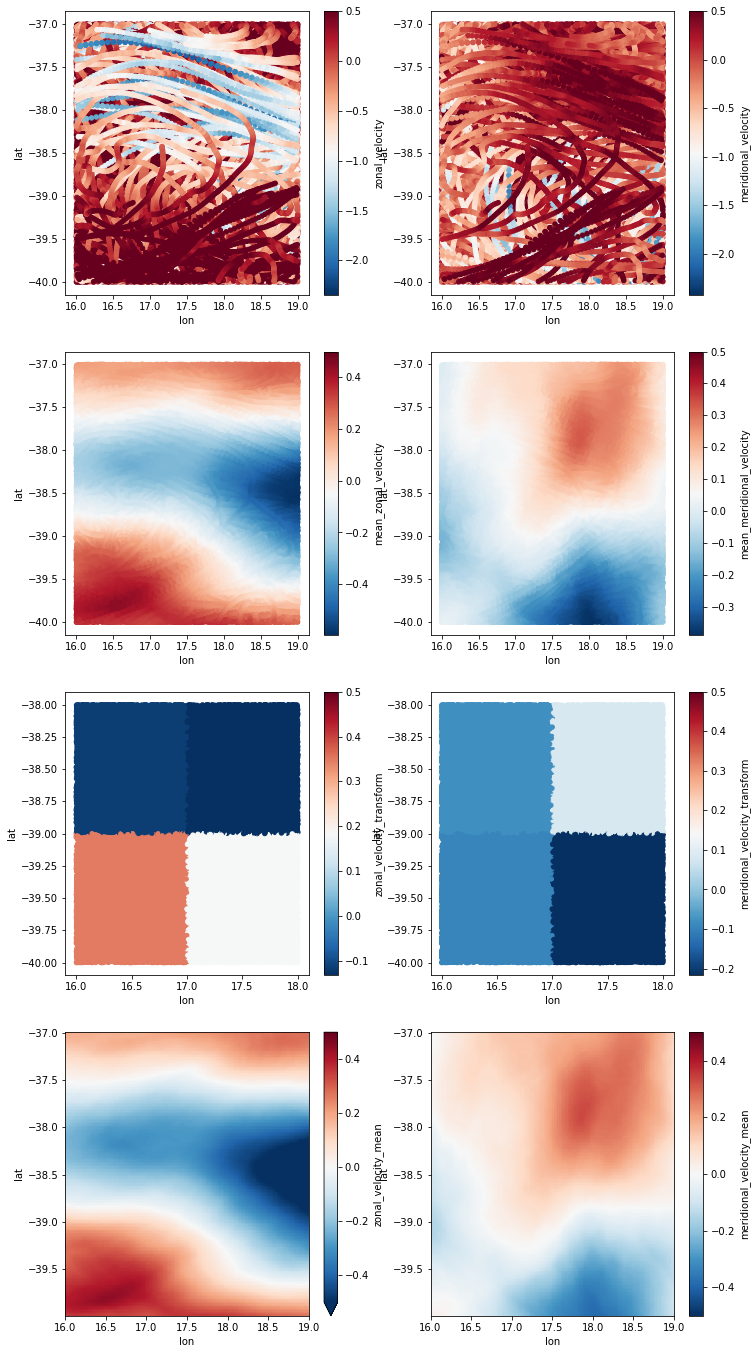

In [33]:
vmax=0.5
fig,ax = plt.subplots(4,2,figsize=(12,24))
df_1dl.plot.scatter(y='lat',x='lon',c='zonal_velocity',ax=ax[0,0],cmap='RdBu_r',vmax=vmax)
df_1dl.plot.scatter(y='lat',x='lon',c='mean_zonal_velocity',ax=ax[1,0],cmap='RdBu_r',vmax=vmax)
df_1dl.plot.scatter(y='lat',x='lon',c='zonal_velocity_transform',ax=ax[2,0],cmap='RdBu_r',vmax=vmax)
df_1dl.plot.scatter(y='lat',x='lon',c='meridional_velocity',ax=ax[0,1],cmap='RdBu_r',vmax=vmax)
df_1dl.plot.scatter(y='lat',x='lon',c='meridional_velocity_transform',ax=ax[2,1],cmap='RdBu_r',vmax=vmax)
df_1dl.plot.scatter(y='lat',x='lon',c='mean_meridional_velocity',ax=ax[1,1],cmap='RdBu_r',vmax=vmax)
ds_Emean.zonal_velocity_mean.plot(y='lat',x='lon',ax=ax[3,0],cmap='RdBu_r',vmax=vmax)
ds_Emean.meridional_velocity_mean.plot(y='lat',x='lon',ax=ax[3,1],cmap='RdBu_r',vmax=vmax)

#### Binned mean

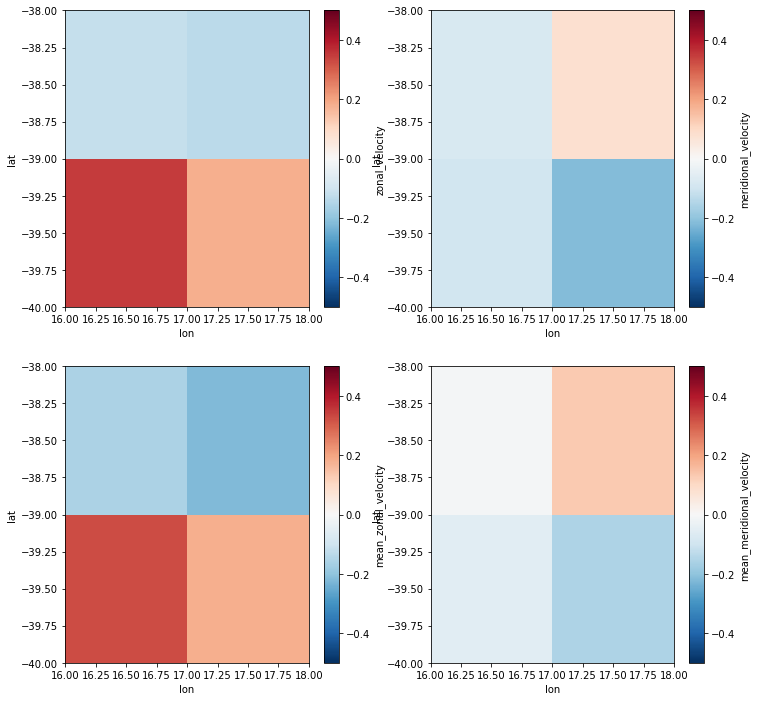

In [28]:
fig,ax = plt.subplots(2,2,figsize=(12,12))
ds_bmean.zonal_velocity.plot(y='lat',ax=ax[0,0],vmax=vmax)
ds_bmean.meridional_velocity.plot(y='lat',ax=ax[0,1],vmax=vmax)
ds_bmean.mean_zonal_velocity.plot(y='lat',ax=ax[1,0],vmax=vmax)
ds_bmean.mean_meridional_velocity.plot(y='lat',ax=ax[1,1],vmax=vmax)

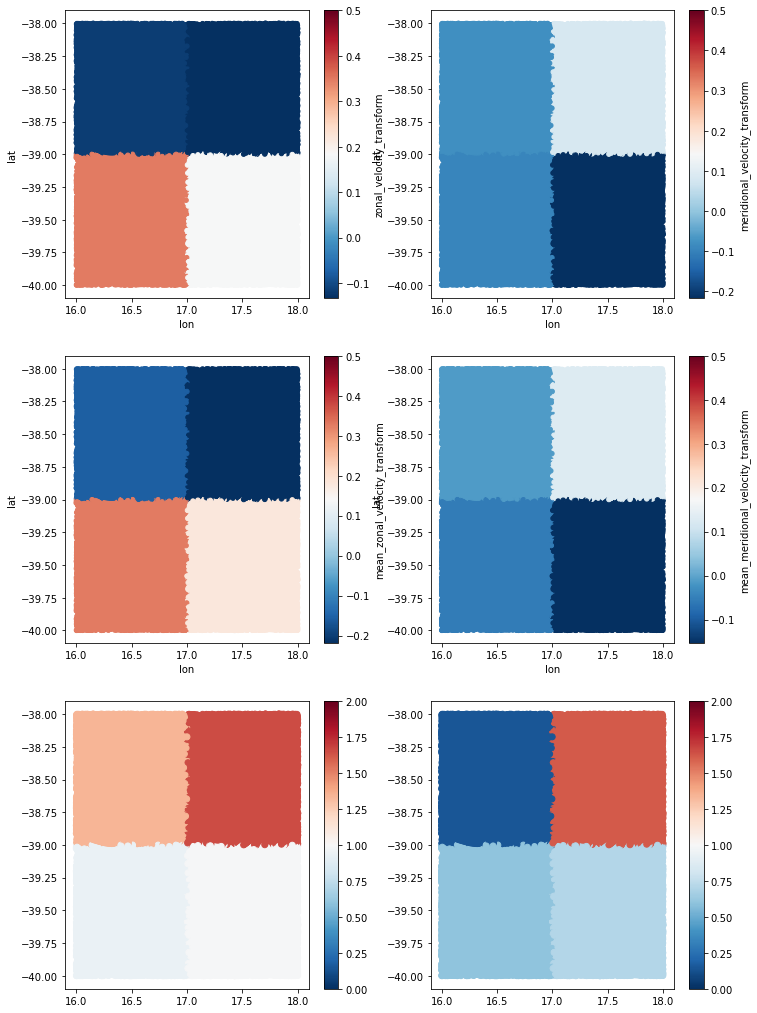

In [71]:
vmax=0.5
fig,ax = plt.subplots(3,2,figsize=(12,18))
df_1dl.plot.scatter(y='lat',x='lon',c='zonal_velocity_transform',ax=ax[0,0],cmap='RdBu_r',vmax=vmax)
df_1dl.plot.scatter(y='lat',x='lon',c='mean_zonal_velocity_transform',ax=ax[1,0],cmap='RdBu_r',vmax=vmax)
df_1dl.plot.scatter(y='lat',x='lon',c='meridional_velocity_transform',ax=ax[0,1],cmap='RdBu_r',vmax=vmax)
df_1dl.plot.scatter(y='lat',x='lon',c='mean_meridional_velocity_transform',ax=ax[1,1],cmap='RdBu_r',vmax=vmax)
cs = ax[2,0].scatter(df_1dl.lon,df_1dl.lat,
                     c=np.abs(df_1dl.mean_zonal_velocity_transform/df_1dl.zonal_velocity_transform)
                     ,cmap='RdBu_r',vmax=2,vmin=0)
plt.colorbar(cs,ax=ax[2,0])
cs = ax[2,1].scatter(df_1dl.lon,df_1dl.lat,
                c=np.abs(df_1dl.mean_meridional_velocity_transform/df_1dl.meridional_velocity_transform)
                     ,cmap='RdBu_r',vmax=2,vmin=0)
plt.colorbar(cs,ax=ax[2,1])

In [30]:
for V in ['zonal_velocity','meridional_velocity','mean_zonal_velocity','mean_meridional_velocity']:
    df_1dl[V+'_transform_square'] = df_1dl[V+'_transform']**2

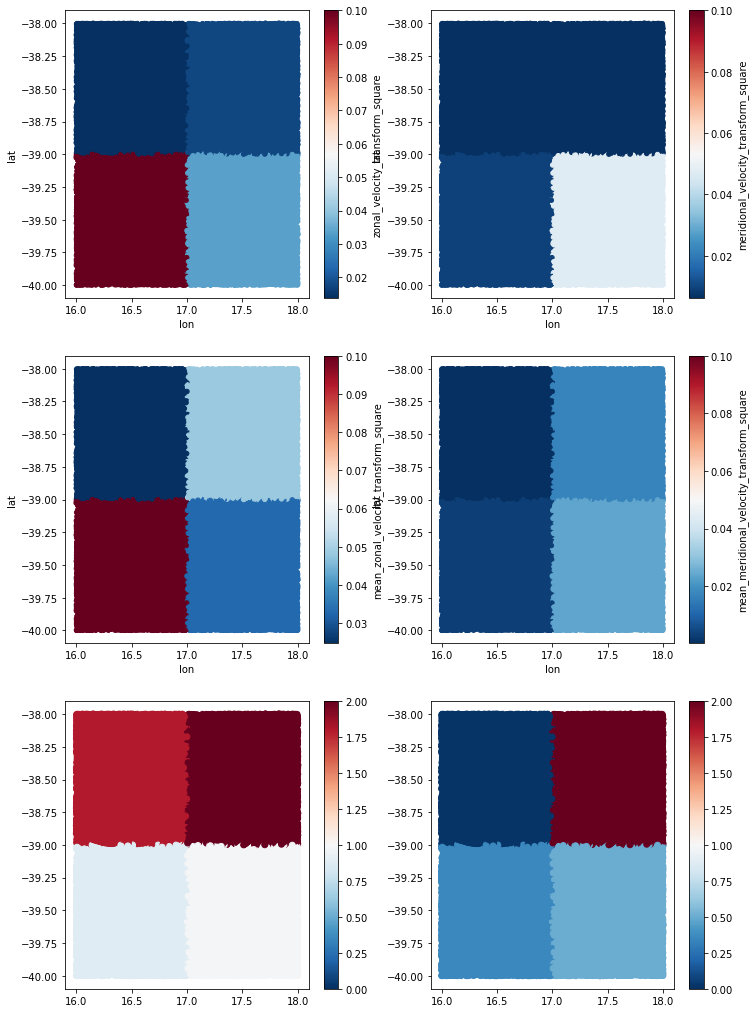

In [72]:
vmax=0.1
fig,ax = plt.subplots(3,2,figsize=(12,18))
df_1dl.plot.scatter(y='lat',x='lon',c='zonal_velocity_transform_square',ax=ax[0,0],cmap='RdBu_r',vmax=vmax)
df_1dl.plot.scatter(y='lat',x='lon',c='mean_zonal_velocity_transform_square',ax=ax[1,0],cmap='RdBu_r',vmax=vmax)
df_1dl.plot.scatter(y='lat',x='lon',c='meridional_velocity_transform_square',ax=ax[0,1],cmap='RdBu_r',vmax=vmax)
df_1dl.plot.scatter(y='lat',x='lon',c='mean_meridional_velocity_transform_square',ax=ax[1,1],cmap='RdBu_r',vmax=vmax)
cs = ax[2,0].scatter(df_1dl.lon,df_1dl.lat,
                     c=df_1dl.mean_zonal_velocity_transform_square/df_1dl.zonal_velocity_transform_square
                     ,cmap='RdBu_r',vmax=2,vmin=0)
plt.colorbar(cs,ax=ax[2,0])
cs = ax[2,1].scatter(df_1dl.lon,df_1dl.lat,
                c=df_1dl.mean_meridional_velocity_transform_square/df_1dl.meridional_velocity_transform_square,
                     cmap='RdBu_r',vmax=2,vmin=0)
plt.colorbar(cs,ax=ax[2,1])

#### $<u>^2+<v>^2$ vs $<<u>^2+<v>^2>$

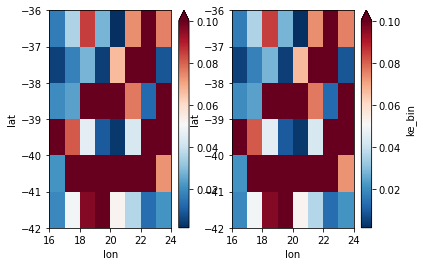

In [55]:
fig,ax = plt.subplots(1,2)
(ds_bmean.zonal_velocity**2+ds_bmean.meridional_velocity**2).plot(ax=ax[0],y='lat',cmap='RdBu_r',vmax=0.1)
ds_bmean.ke_bin.plot(ax=ax[1],y='lat',cmap='RdBu_r',vmax=0.1)

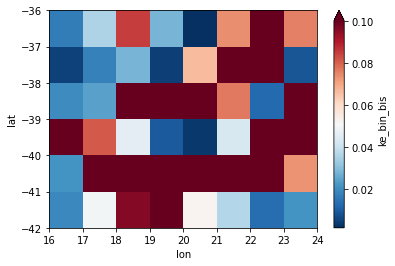

In [54]:
ds_bmean.ke_bin_bis.plot(y='lat',cmap='RdBu_r',vmax=0.1)

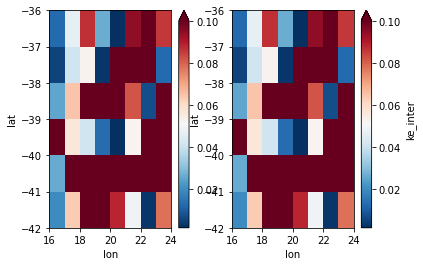

In [71]:
fig,ax = plt.subplots(1,2)
(ds_bmean.mean_zonal_velocity**2+ds_bmean.mean_meridional_velocity**2).plot(ax=ax[0],y='lat',cmap='RdBu_r',vmax=0.1)
ds_bmean.ke_inter.plot(ax=ax[1],y='lat',cmap='RdBu_r',vmax=0.1)

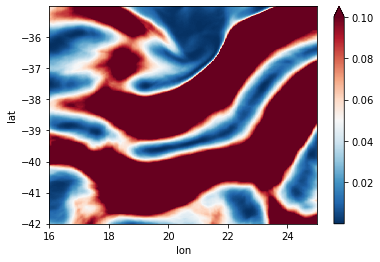

In [68]:
(ds_Emean.zonal_velocity_mean**2+ds_Emean.meridional_velocity_mean**2).plot(y='lat',cmap='RdBu_r',vmax=0.1)

#### Repartition number of floats

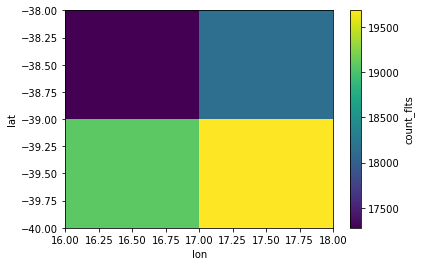

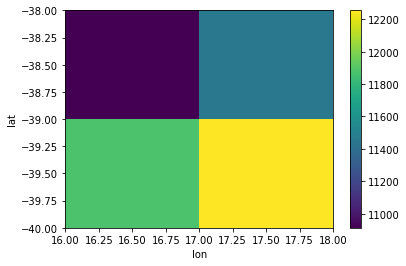

In [34]:
ds_bmean.count_flts.plot(y='lat')
plt.figure()
(ds_bmean.count_flts/ds_bmean.area).plot(y='lat')

In [35]:
group=['lon_cut','lat_cut','time_cut']
df_mean = df_1dl.groupby(group).mean()

In [82]:
df_mean = pa.add_geodata(df_mean)


df_mean['time'] = df_mean.index.to_frame().time_cut.apply(lambda d: d.left)
df_mean = df_mean.set_index(['lon','lat','time'])

In [84]:
ds_mean = (df_mean
           .drop(columns=['Coordinates'])
           .to_xarray()
           )

In [72]:
count = (df_1dl
         .groupby(group)
         .count()['z']
         .rename('count')
         .to_frame()
        )
count = pa.add_geodata(count)


count['time'] = count.index.to_frame().time_cut.apply(lambda d: d.left)
count = count.set_index(['lon','lat','time'])
#count = count/30 # normalize per number of days

In [73]:
count

count  \
lon  lat   time                         
16.5 -39.5 2011-12-01 00:00:00    691   
           2012-01-01 00:00:00   1390   
           2012-02-01 00:00:00   1171   
           2012-03-01 00:00:00   1451   
           2012-04-01 00:00:00   2074   
           2012-05-01 00:00:00   1628   
           2012-06-01 00:00:00   1868   
           2012-07-01 00:00:00   2023   
           2012-08-01 00:00:00   2120   
           2012-09-01 00:00:00   1979   
           2012-10-01 00:00:00   1583   
     -38.5 2011-12-01 00:00:00   1236   
           2012-01-01 00:00:00   1257   
           2012-02-01 00:00:00   1383   
           2012-03-01 00:00:00   1270   
           2012-04-01 00:00:00   1138   
           2012-05-01 00:00:00   2754   
           2012-06-01 00:00:00   1901   
           2012-07-01 00:00:00    630   
           2012-08-01 00:00:00   1060   
           2012-09-01 00:00:00   2094   
           2012-10-01 00:00:00   1627   
17.5 -39.5 2011-12-01 00:00:00   1405   
           2012-01-01 00:00:00   2120   
           2012-02-01 00:00:00    934   
           2012-03-01 00:00:00   1670   
           2012-04-01 00:00:00   1819   
           2012-05-01 00:00:00   1692   
           2012-06-01 00:00:00   1940   
           2012-07-01 00:00:00   1698   
           2012-08-01 00:00:00   1980   
           2012-09-01 00:00:00   2412   
           2012-10-01 00:00:00    814   
     -38.5 2011-12-01 00:00:00   1419   
           2012-01-01 00:00:00   1260   
           2012-02-01 00:00:00   1463   
           2012-03-01 00:00:00   2708   
           2012-04-01 00:00:00   1546   
           2012-05-01 00:00:00   1437   
           2012-06-01 00:00:00   1783   
           2012-07-01 00:00:00   1046   
           2012-08-01 00:00:00    844   
           2012-09-01 00:00:00   2851   
           2012-10-01 00:00:00    955   

                                                                      Coordinates  \
lon  lat   time                                                                     
16.5 -39.5 2011-12-01 00:00:00  POLYGON ((16.00000 -40.00000, 17.00000 -40.000...   
           2012-01-01 00:00:00  POLYGON ((16.00000 -40.00000, 17.00000 -40.000...   
           2012-02-01 00:00:00  POLYGON ((16.00000 -40.00000, 17.00000 -40.000...   
           2012-03-01 00:00:00  POLYGON ((16.00000 -40.00000, 17.00000 -40.000...   
           2012-04-01 00:00:00  POLYGON ((16.00000 -40.00000, 17.00000 -40.000...   
           2012-05-01 00:00:00  POLYGON ((16.00000 -40.00000, 17.00000 -40.000...   
           2012-06-01 00:00:00  POLYGON ((16.00000 -40.00000, 17.00000 -40.000...   
           2012-07-01 00:00:00  POLYGON ((16.00000 -40.00000, 17.00000 -40.000...   
           2012-08-01 00:00:00  POLYGON ((16.00000 -40.00000, 17.00000 -40.000...   
           2012-09-01 00:00:00  POLYGON ((16.00000 -40.00000, 17.00000 -40.000...   
           2012-10-01 00:00:00  POLYGON ((16.00000 -40.00000, 17.00000 -40.000...   
     -38.5 2011-12-01 00:00:00  POLYGON ((16.00000 -39.00000, 17.00000 -39.000...   
           2012-01-01 00:00:00  POLYGON ((16.00000 -39.00000, 17.00000 -39.000...   
           2012-02-01 00:00:00  POLYGON ((16.00000 -39.00000, 17.00000 -39.000...   
           2012-03-01 00:00:00  POLYGON ((16.00000 -39.00000, 17.00000 -39.000...   
           2012-04-01 00:00:00  POLYGON ((16.00000 -39.00000, 17.00000 -39.000...   
           2012-05-01 00:00:00  POLYGON ((16.00000 -39.00000, 17.00000 -39.000...   
           2012-06-01 00:00:00  POLYGON ((16.00000 -39.00000, 17.00000 -39.000...   
           2012-07-01 00:00:00  POLYGON ((16.00000 -39.00000, 17.00000 -39.000...   
           2012-08-01 00:00:00  POLYGON ((16.00000 -39.00000, 17.00000 -39.000...   
           2012-09-01 00:00:00  POLYGON ((16.00000 -39.00000, 17.00000 -39.000...   
           2012-10-01 00:00:00  POLYGON ((16.00000 -39.00000, 17.00000 -39.000...   
17.5 -39.5 2011-12-01 00:00:00  POLYGON ((17.00000 -40.00000, 18.00000 -40.000...   
           2012-01-0

In [74]:
count = count.drop(columns=['Coordinates']).to_xarray()

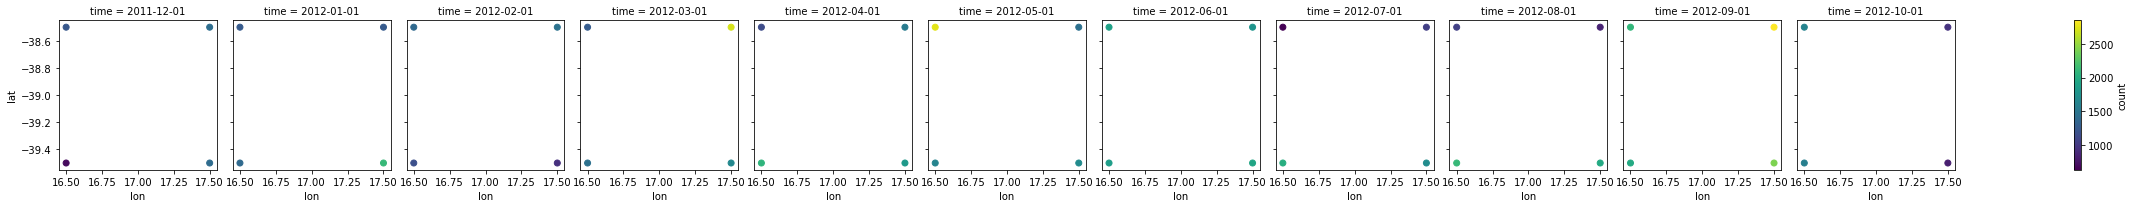

In [80]:
count.plot.scatter(x='lon',y='lat',col='time',hue='count')

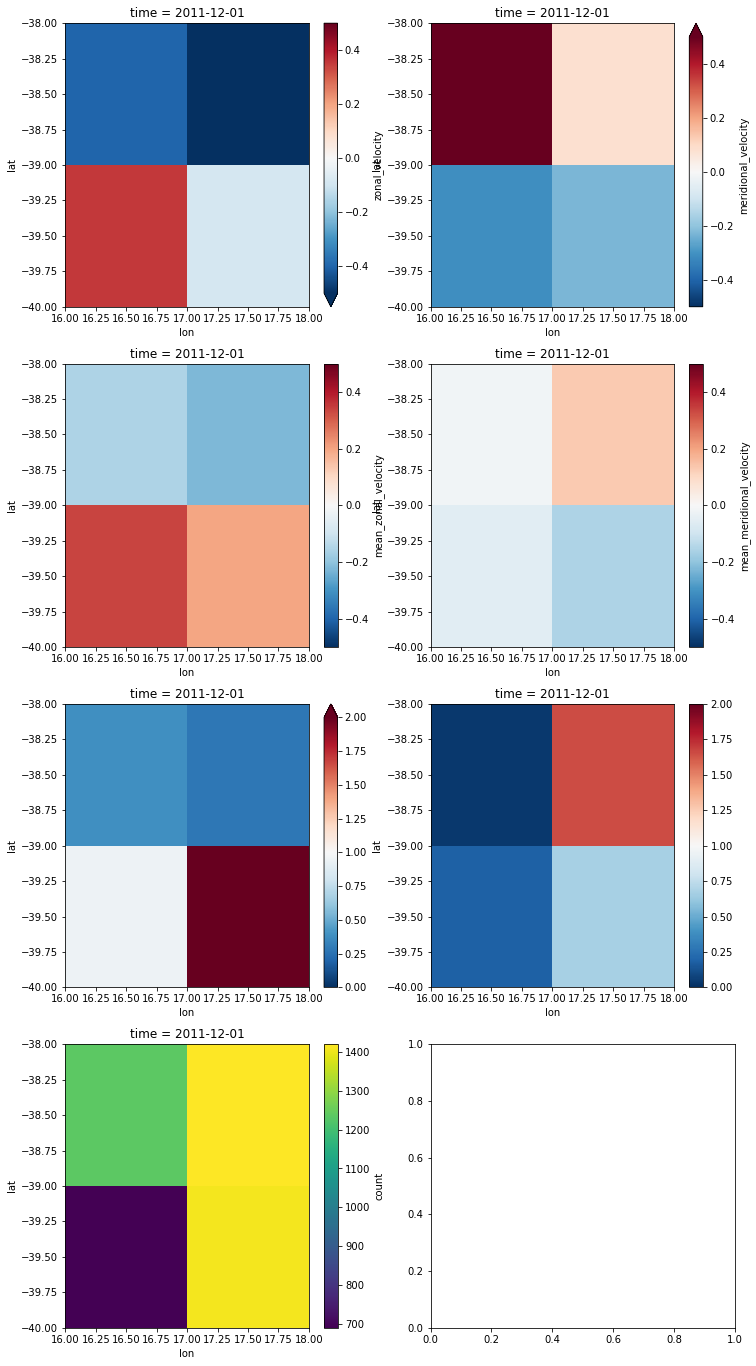

In [94]:
vmax=0.5
fig,ax = plt.subplots(4,2,figsize=(12,24))
ds_mean.zonal_velocity.isel(time=0).plot(y='lat',ax=ax[0,0],vmax=vmax)
ds_mean.meridional_velocity.isel(time=0).plot(y='lat',ax=ax[0,1],vmax=vmax)
ds_mean.mean_zonal_velocity.isel(time=0).plot(y='lat',ax=ax[1,0],vmax=vmax)
ds_mean.mean_meridional_velocity.isel(time=0).plot(y='lat',ax=ax[1,1],vmax=vmax)
np.abs(ds_mean.mean_zonal_velocity/ds_mean.zonal_velocity).isel(time=0).plot(y='lat',ax=ax[2,0],vmax=2,vmin=0,cmap='RdBu_r')
np.abs(ds_mean.mean_meridional_velocity/ds_mean.meridional_velocity).isel(time=0).plot(y='lat',ax=ax[2,1],vmax=2,vmin=0,cmap='RdBu_r')
count.isel(time=0)['count'].plot(y='lat',ax=ax[3,0])

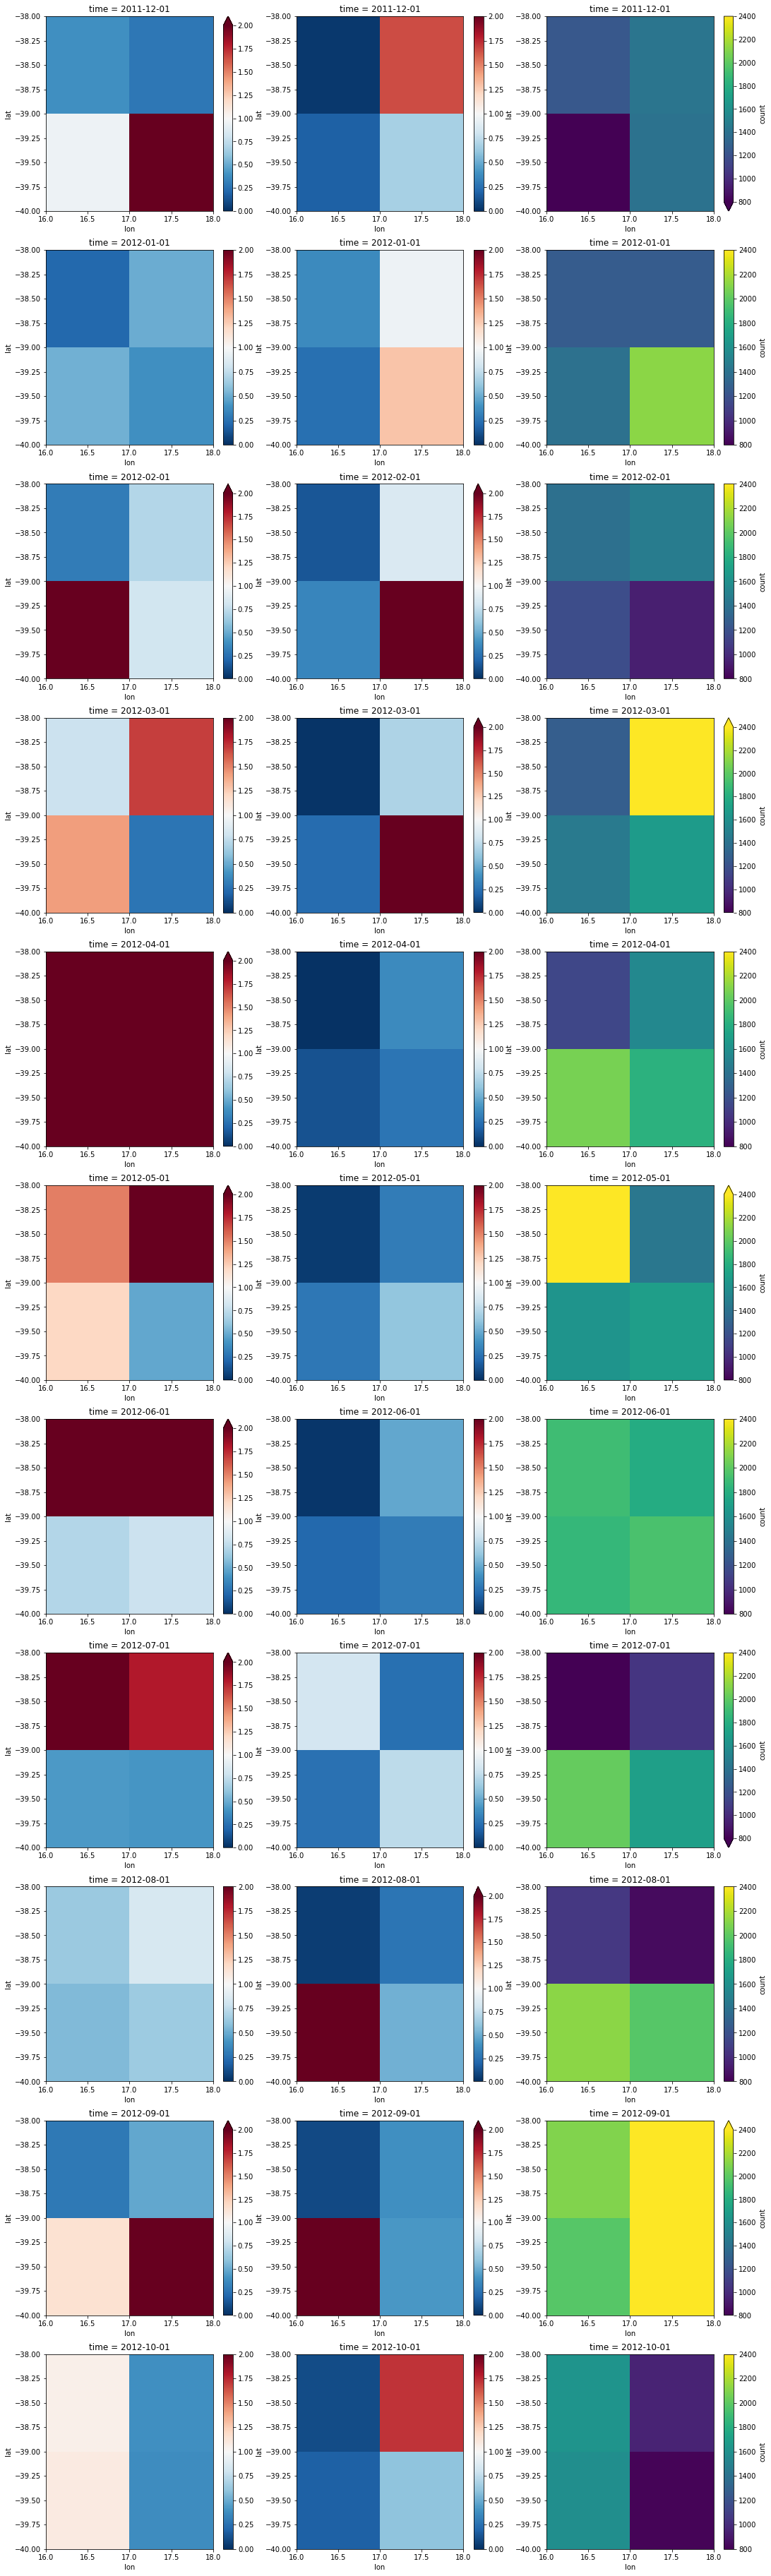

In [98]:
vmax=0.5
fig,ax = plt.subplots(count.time.size,3,figsize=(18,count.time.size*6))
for i in range(count.time.size):
    np.abs(ds_mean.mean_zonal_velocity/ds_mean.zonal_velocity).isel(time=i).plot(y='lat',ax=ax[i,0],vmax=2,vmin=0,cmap='RdBu_r')
    np.abs(ds_mean.mean_meridional_velocity/ds_mean.meridional_velocity).isel(time=i).plot(y='lat',ax=ax[i,1],vmax=2,vmin=0,cmap='RdBu_r')
    count.isel(time=i)['count'].plot(y='lat',ax=ax[i,2],vmax=2400,vmin = 800)

#### Bins of 0.1° width:

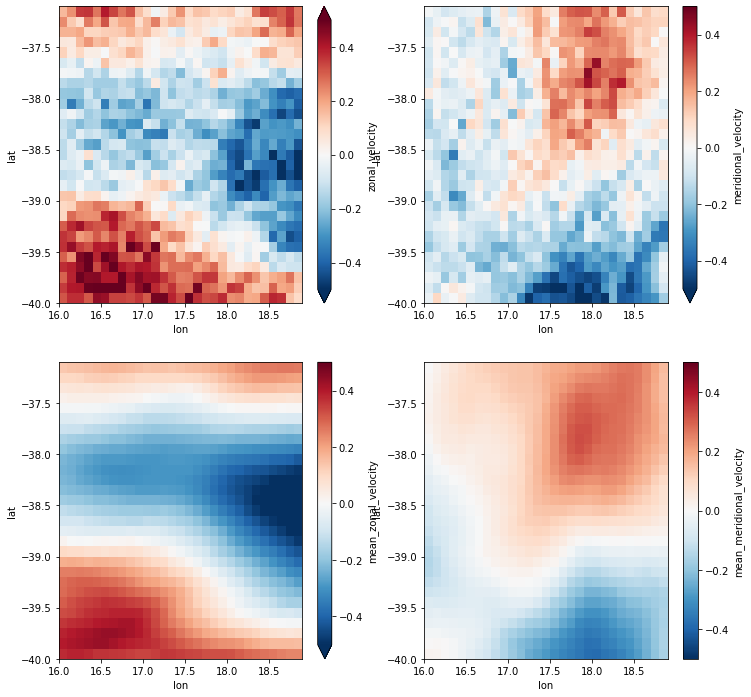

In [49]:
vmax= 0.5

fig,ax = plt.subplots(2,2,figsize=(12,12))
ds_bmean.zonal_velocity.plot(y='lat',ax=ax[0,0],vmax=vmax)
ds_bmean.meridional_velocity.plot(y='lat',ax=ax[0,1],vmax=vmax)
ds_bmean.mean_zonal_velocity.plot(y='lat',ax=ax[1,0],vmax=vmax)
ds_bmean.mean_meridional_velocity.plot(y='lat',ax=ax[1,1],vmax=vmax)

/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
/home1/datahome/zcaspar/m

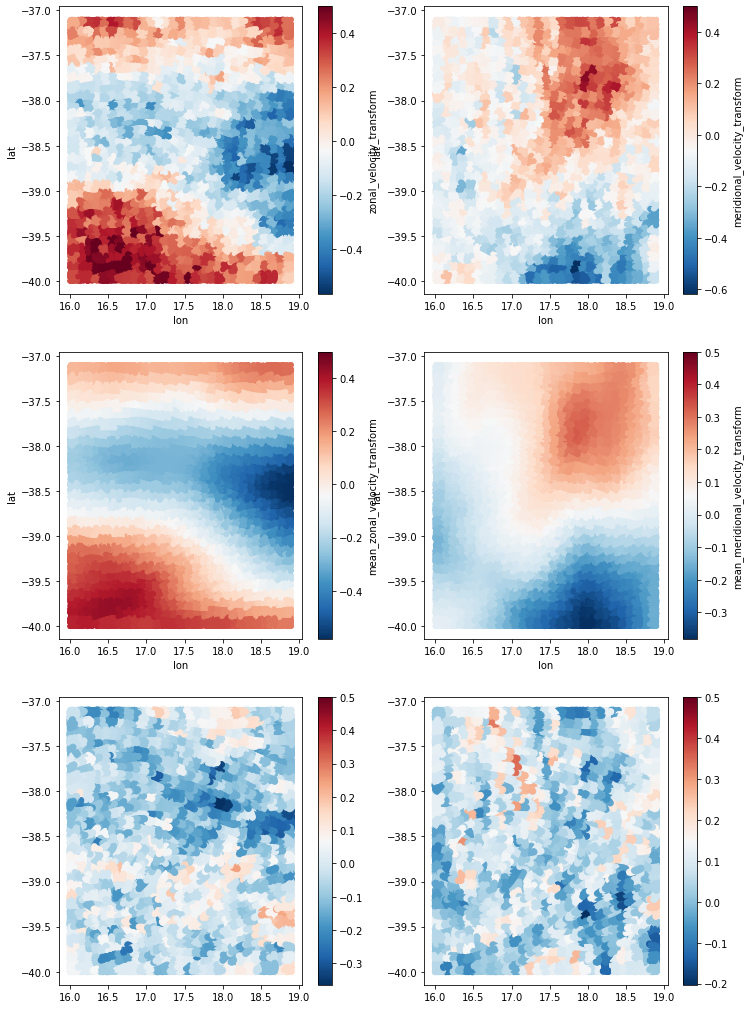

In [63]:
vmax=0.5
fig,ax = plt.subplots(3,2,figsize=(12,18))
df_01dl.plot.scatter(y='lat',x='lon',c='zonal_velocity_transform',ax=ax[0,0],cmap='RdBu_r',vmax=vmax)
df_01dl.plot.scatter(y='lat',x='lon',c='mean_zonal_velocity_transform',ax=ax[1,0],cmap='RdBu_r',vmax=vmax)
df_01dl.plot.scatter(y='lat',x='lon',c='meridional_velocity_transform',ax=ax[0,1],cmap='RdBu_r',vmax=vmax)
df_01dl.plot.scatter(y='lat',x='lon',c='mean_meridional_velocity_transform',ax=ax[1,1],cmap='RdBu_r',vmax=vmax)
cs = ax[2,0].scatter(df_01dl.lon,df_01dl.lat,
                     c=df_01dl.mean_zonal_velocity_transform-df_01dl.zonal_velocity_transform,cmap='RdBu_r',vmax=vmax)
plt.colorbar(cs,ax=ax[2,0])
cs = ax[2,1].scatter(df_01dl.lon,df_01dl.lat,
                c=df_01dl.mean_meridional_velocity_transform-df_01dl.meridional_velocity_transform,cmap='RdBu_r',vmax=vmax)
plt.colorbar(cs,ax=ax[2,1])

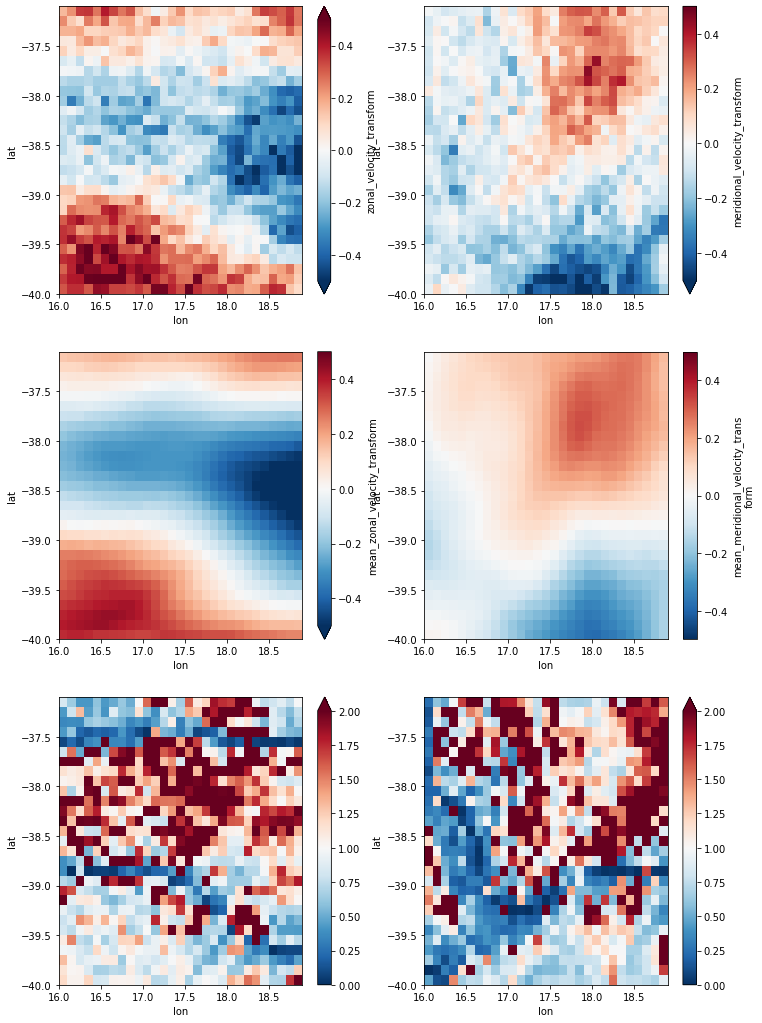

In [70]:
vmax= 0.5

fig,ax = plt.subplots(3,2,figsize=(12,18))
ds_bmean.zonal_velocity_transform.plot(y='lat',ax=ax[0,0],vmax=vmax)
ds_bmean.meridional_velocity_transform.plot(y='lat',ax=ax[0,1],vmax=vmax)

ds_bmean.mean_zonal_velocity_transform.plot(y='lat',ax=ax[1,0],vmax=vmax)
ds_bmean.mean_meridional_velocity_transform.plot(y='lat',ax=ax[1,1],vmax=vmax)

np.abs(ds_bmean.mean_zonal_velocity_transform/ds_bmean.zonal_velocity_transform).plot(y='lat',ax=ax[2,0],
                                                                                      cmap='RdBu_r',vmax=2,vmin=0)
np.abs(ds_bmean.mean_meridional_velocity_transform/ds_bmean.meridional_velocity_transform).plot(y='lat',ax=ax[2,1],
                                                                                          cmap='RdBu_r',vmax=2,vmin=0)

In [73]:
for V in ['zonal_velocity','meridional_velocity','mean_zonal_velocity','mean_meridional_velocity']:
    df_01dl[V+'_transform_square'] = df_01dl[V+'_transform']**2

/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
/home1/datahome/zcaspar/m

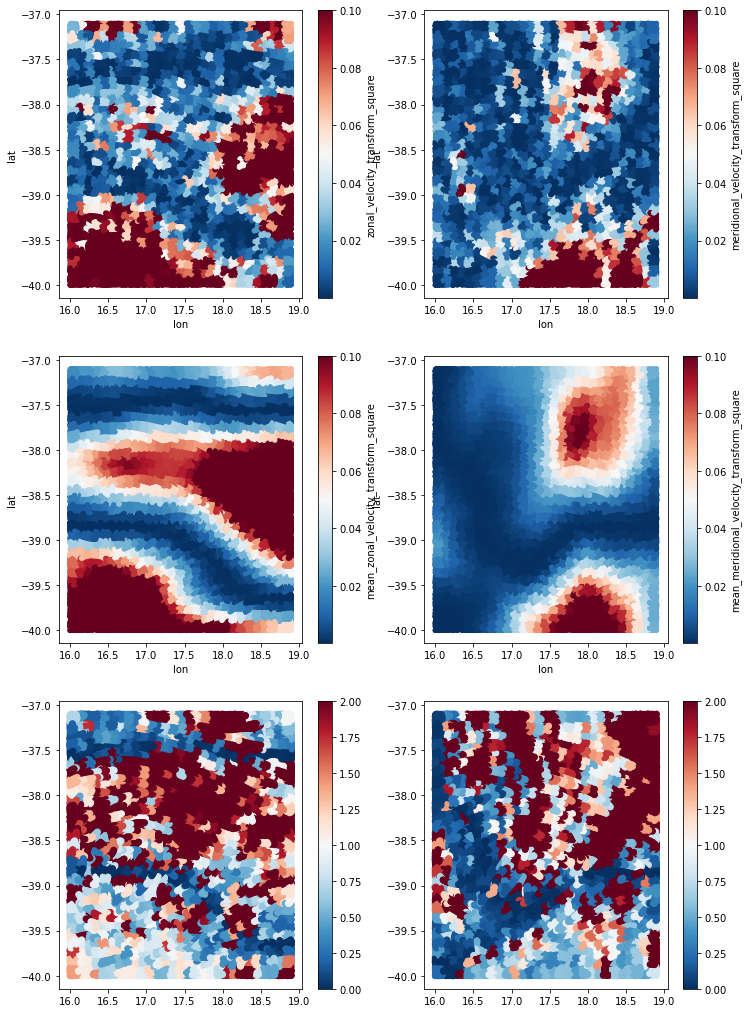

In [74]:
vmax=0.1
fig,ax = plt.subplots(3,2,figsize=(12,18))
df_01dl.plot.scatter(y='lat',x='lon',c='zonal_velocity_transform_square',ax=ax[0,0],cmap='RdBu_r',vmax=vmax)
df_01dl.plot.scatter(y='lat',x='lon',c='mean_zonal_velocity_transform_square',ax=ax[1,0],cmap='RdBu_r',vmax=vmax)
df_01dl.plot.scatter(y='lat',x='lon',c='meridional_velocity_transform_square',ax=ax[0,1],cmap='RdBu_r',vmax=vmax)
df_01dl.plot.scatter(y='lat',x='lon',c='mean_meridional_velocity_transform_square',ax=ax[1,1],cmap='RdBu_r',vmax=vmax)
cs = ax[2,0].scatter(df_01dl.lon,df_01dl.lat,
                     c=df_01dl.mean_zonal_velocity_transform_square/df_01dl.zonal_velocity_transform_square
                     ,cmap='RdBu_r',vmax=2,vmin=0)
plt.colorbar(cs,ax=ax[2,0])
cs = ax[2,1].scatter(df_01dl.lon,df_01dl.lat,
                c=df_01dl.mean_meridional_velocity_transform_square/df_01dl.meridional_velocity_transform_square,
                     cmap='RdBu_r',vmax=2,vmin=0)
plt.colorbar(cs,ax=ax[2,1])

### Test 1 partition

In [11]:
df_sub = df_sub.compute()

In [10]:
df_sub['zonal_velocity_mean_transform'] = df_sub.groupby(['lon_cut','lat_cut']).zonal_velocity.transform('mean')
df_sub['meridional_velocity_mean_transform'] = df_sub.groupby(['lon_cut','lat_cut']).meridional_velocity.transform('mean')

<ipython-input-10-ce0780c20d9c>:1: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .transform(func)
  After:  .transform(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .transform(func, meta=('x', 'f8'))            for series result
  df_sub['zonal_velocity_mean_transform'] = df_sub.groupby(['lon_cut','lat_cut']).zonal_velocity.transform('mean')
<ipython-input-10-ce0780c20d9c>:2: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .transform(func)
  After:  .transform(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .transform(func, meta=('x', 'f8'))            for series result
  df_sub['meridional_velocity_mean_transform'] = df_sub.groupby(['lon_cut','lat_cut']).meridional_velocity.transform('mean')


In [38]:
df_sub['zonal_velocity_mean_transform_sq'] = df_sub['zonal_velocity_mean_transform']**2

In [12]:
df_sub['velocity_amplitude'] = np.sqrt(df_sub['zonal_velocity']**2+df_sub['meridional_velocity']**2)
df_sub['mean_velocity_amplitude'] = np.sqrt(df_sub['mean_zonal_velocity']**2+df_sub['mean_meridional_velocity']**2)
df_sub['velocity_amplitude_mean_transform'] = np.sqrt(df_sub['zonal_velocity_mean_transform']**2+df_sub['meridional_velocity_mean_transform']**2)


In [13]:
group=['lon_cut','lat_cut']
mean_flts = df_sub.groupby(group).mean()

In [14]:
mean_flts = pa.add_geodata(mean_flts)
ds_mean = (mean_flts
           .drop(columns=['Coordinates'])
           .set_index(['lon', 'lat'])
           .to_xarray()
           )

(-180.407, -120.0)

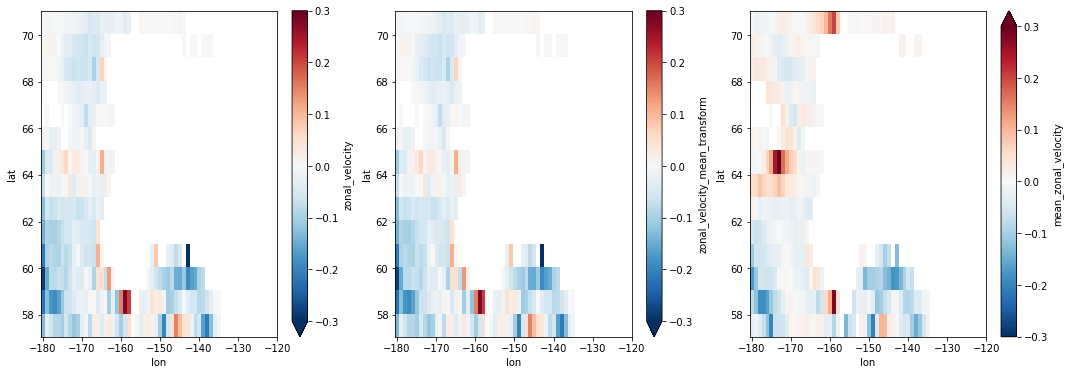

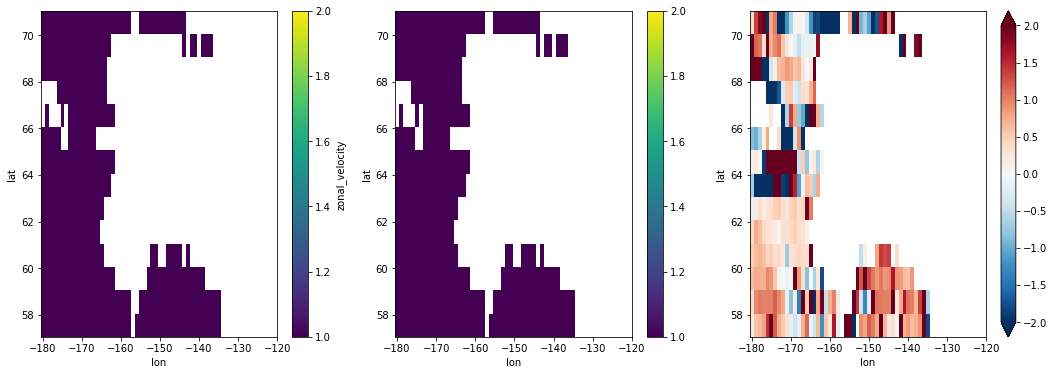

In [20]:
fig,ax = plt.subplots(1,3,figsize=(18,6))
ds_mean.zonal_velocity.plot(y='lat',vmax=0.3,ax=ax[0])
ax[0].set_xlim(None,-120)
ds_mean.zonal_velocity_mean_transform.plot(y='lat',vmax=0.3,ax=ax[1])
ax[1].set_xlim(None,-120)
ds_mean.mean_zonal_velocity.plot(y='lat',vmax=0.3,ax=ax[2])
ax[2].set_xlim(None,-120)
fig,ax = plt.subplots(1,3,figsize=(18,6))
(ds_mean.zonal_velocity/ds_mean.zonal_velocity).plot(y='lat',vmax=2,ax=ax[0])
ax[0].set_xlim(None,-120)
(ds_mean.zonal_velocity_mean_transform/ds_mean.zonal_velocity).plot(y='lat',vmax=2,ax=ax[1])
ax[1].set_xlim(None,-120)
(ds_mean.mean_zonal_velocity/ds_mean.zonal_velocity).plot(y='lat',vmax=2,ax=ax[2])
ax[2].set_xlim(None,-120)

(-180.407, -120.0)

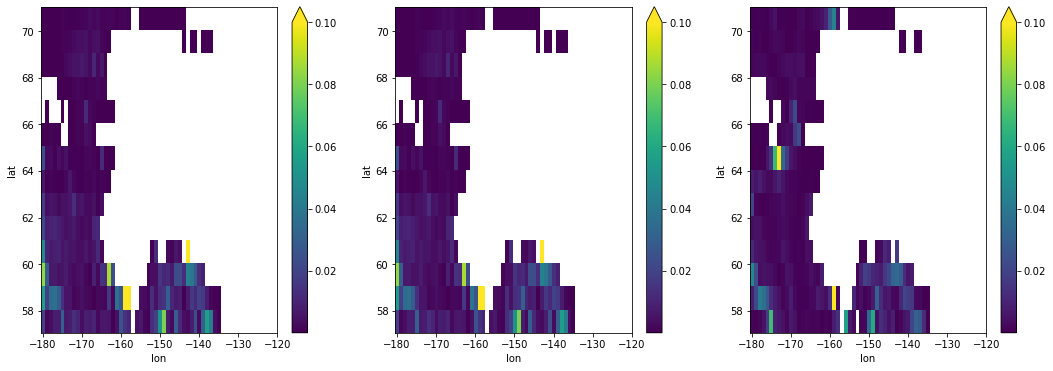

In [22]:
fig,ax = plt.subplots(1,3,figsize=(18,6))
(ds_mean.zonal_velocity**2+ds_mean.meridional_velocity**2).plot(y='lat',vmax=0.1,ax=ax[0])
ax[0].set_xlim(None,-120)
(ds_mean.zonal_velocity_mean_transform**2+ds_mean.meridional_velocity_mean_transform**2).plot(y='lat',vmax=0.1,ax=ax[1])
ax[1].set_xlim(None,-120)
(ds_mean.mean_zonal_velocity**2+ds_mean.mean_meridional_velocity**2).plot(y='lat',vmax=0.1,ax=ax[2])
ax[2].set_xlim(None,-120)

In [7]:
cluster.close()

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
asyncio.exceptions.CancelledError
